In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import sys
import os
import importlib

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Add parent directory to path for imports
sys.path.append('..')

print("📦 Libraries imported successfully!")


📦 Libraries imported successfully!


In [2]:
def get_latest_trained_models():
    """Find and return paths to the latest trained models using versioning."""
    model_dir = Path('.')
    
    # Find all training directories
    training_dirs = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith('training_')]
    
    if not training_dirs:
        # Fallback to standard model locations
        print("⚠️  No training directories found, using standard model locations...")
        return {
            'winner_model_path': 'ufc_random_forest_model_tuned.joblib',
            'method_model_path': 'ufc_multiclass_model.joblib',
            'winner_cols_path': 'winner_model_columns.json',
            'method_cols_path': 'method_model_columns.json',
            'fighters_data_path': 'ufc_fighters_engineered_corrected.csv',
            'version': 'standard'
        }
    
    # Sort by directory name to get the latest (assuming timestamp format)
    latest_training_dir = sorted(training_dirs, key=lambda x: x.name)[-1]
    version = latest_training_dir.name.replace('training_', '')
    
    print(f"✅ Using latest training version: {version}")
    
    # Build paths for versioned models
    return {
        'winner_model_path': latest_training_dir / f'ufc_winner_model_tuned_{version}.joblib',
        'method_model_path': latest_training_dir / f'ufc_method_model_{version}.joblib',
        'winner_cols_path': latest_training_dir / f'winner_model_columns_{version}.json',
        'method_cols_path': latest_training_dir / f'method_model_columns_{version}.json',
        'fighters_data_path': latest_training_dir / f'ufc_fighters_engineered_{version}.csv',
        'version': version
    }

def load_models_and_data():
    """Load the latest models and data."""
    print("📊 Loading latest models and data...")
    
    # Get latest model paths
    paths = get_latest_trained_models()
    
    # Load fighter data
    fighters_data_path = paths['fighters_data_path']
    if not fighters_data_path.exists():
        # Fallback to standard location
        fighters_data_path = Path('ufc_fighters_engineered_corrected.csv')
    
    fighters_df = pd.read_csv(fighters_data_path)
    print(f"✅ Loaded {len(fighters_df):,} fighter records")
    
    # Load column configurations
    with open(paths['winner_cols_path'], 'r') as f:
        winner_cols = json.load(f)
    
    with open(paths['method_cols_path'], 'r') as f:
        method_cols = json.load(f)
    
    print(f"✅ Loaded column configurations: {len(winner_cols)} winner features, {len(method_cols)} method features")
    
    # Load trained models
    winner_model = joblib.load(paths['winner_model_path'])
    method_model = joblib.load(paths['method_model_path'])
    
    print(f"✅ Loaded models from training version: {paths['version']}")
    print(f"   - Winner model: {winner_model.__class__.__name__}")
    print(f"   - Method model: {method_model.__class__.__name__}")
    
    return {
        'fighters_df': fighters_df,
        'winner_cols': winner_cols,
        'method_cols': method_cols,
        'winner_model': winner_model,
        'method_model': method_model,
        'version': paths['version'],
        'model_paths': paths
    }

# Load all models and data
model_data = load_models_and_data()
fighters_df = model_data['fighters_df']
winner_cols = model_data['winner_cols']
method_cols = model_data['method_cols']
winner_model = model_data['winner_model']
method_model = model_data['method_model']
print("\n✅ All models and data loaded successfully!")


📊 Loading latest models and data...
✅ Using latest training version: 2025-07-23_09-51
✅ Loaded 4,364 fighter records
✅ Loaded column configurations: 70 winner features, 70 method features
✅ Loaded models from training version: 2025-07-23_09-51
   - Winner model: RandomForestClassifier
   - Method model: RandomForestClassifier

✅ All models and data loaded successfully!


In [3]:
# Import prediction function with auto-reload
if 'src.prediction' in sys.modules:
    importlib.reload(sys.modules['src.prediction'])

try:
    from src.prediction import predict_fight_symmetrical
    print("✅ Successfully imported predict_fight_symmetrical!")
except ImportError as e:
    print(f"⚠️  Import error: {e}")
    print("💡 Please restart the Jupyter kernel and try again")
    
    # Define a fallback function if import fails
    def predict_fight_symmetrical(fighter1_name, fighter2_name, fighters_df, winner_cols, method_cols, winner_model, method_model):
        return {"error": "Function not available - please restart kernel and re-run cells"}


✅ Successfully imported predict_fight_symmetrical!


In [4]:
def get_model_info():
    """Display comprehensive model information."""
    print("🤖 MODEL INFORMATION")
    print("=" * 50)
    
    print(f"Training Version: {model_data['version']}")
    print(f"Winner Model: {winner_model.__class__.__name__}")
    if hasattr(winner_model, 'n_estimators'):
        print(f"  - Trees: {winner_model.n_estimators}")
    if hasattr(winner_model, 'max_depth'):
        print(f"  - Max Depth: {winner_model.max_depth}")
    print(f"  - Features: {len(winner_cols)}")
    
    print(f"\nMethod Model: {method_model.__class__.__name__}")
    if hasattr(method_model, 'n_estimators'):
        print(f"  - Trees: {method_model.n_estimators}")
    if hasattr(method_model, 'max_depth'):
        print(f"  - Max Depth: {method_model.max_depth}")
    print(f"  - Features: {len(method_cols)}")
    print(f"  - Classes: {list(method_model.classes_)}")
    
    print(f"\nFighter Database: {len(fighters_df):,} fighters")
    print(f"Model Paths:")
    print(f"  - Winner: {Path(model_data['model_paths']['winner_model_path']).name}")
    print(f"  - Method: {Path(model_data['model_paths']['method_model_path']).name}")

# Display model information
get_model_info()


🤖 MODEL INFORMATION
Training Version: 2025-07-23_09-51
Winner Model: RandomForestClassifier
  - Trees: 300
  - Max Depth: None
  - Features: 70

Method Model: RandomForestClassifier
  - Trees: 200
  - Max Depth: 20
  - Features: 70
  - Classes: ['Decision', 'KO/TKO', 'Submission']

Fighter Database: 4,364 fighters
Model Paths:
  - Winner: ufc_winner_model_tuned_2025-07-23_09-51.joblib
  - Method: ufc_method_model_2025-07-23_09-51.joblib


In [5]:
def predict_single_fight(fighter1, fighter2, show_plot=True):
    """Predict a single fight with optional visualization."""
    print(f"🥊 Predicting: {fighter1} vs {fighter2}")
    print("="*50)
    
    result = predict_fight_symmetrical(
        fighter1, fighter2, fighters_df, 
        winner_cols, method_cols, winner_model, method_model
    )
    
    if 'error' in result:
        print(f"❌ Error: {result['error']}")
        
        # Show similar fighter names
        available_fighters = fighters_df['Name'].tolist()
        similar1 = [f for f in available_fighters if fighter1.lower() in f.lower()][:5]
        similar2 = [f for f in available_fighters if fighter2.lower() in f.lower()][:5]
        
        if similar1:
            print(f"Similar to '{fighter1}': {', '.join(similar1)}")
        if similar2:
            print(f"Similar to '{fighter2}': {', '.join(similar2)}")
        return None
    
    # Display results
    print(f"🏆 Predicted Winner: {result['predicted_winner']} ({result['winner_confidence']})")
    print(f"⚔️  Predicted Method: {result['predicted_method']}")
    
    print(f"\n📊 Win Probabilities:")
    for fighter, prob in result['win_probabilities'].items():
        print(f"   {fighter}: {prob}")
    
    print(f"\n🥊 Method Probabilities:")
    for method, prob in result['method_probabilities'].items():
        print(f"   {method}: {prob}")
    
    # Create visualization
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Winner probability pie chart
        fighters = list(result['win_probabilities'].keys())
        win_probs = [float(p.replace('%', '')) for p in result['win_probabilities'].values()]
        colors = ['#FF6B6B', '#4ECDC4']
        
        wedges, texts, autotexts = ax1.pie(win_probs, labels=fighters, autopct='%1.1f%%', 
                                          colors=colors, startangle=90, textprops={'fontsize': 12})
        ax1.set_title(f'Winner Prediction\n{result["predicted_winner"]} Wins', fontsize=14, fontweight='bold')
        
        # Method probability bar chart
        methods = list(result['method_probabilities'].keys())
        method_probs = [float(p.replace('%', '')) for p in result['method_probabilities'].values()]
        
        bars = ax2.bar(methods, method_probs, color=['#FFD93D', '#FF6B6B', '#6BCF7F'])
        ax2.set_title(f'Method Prediction\n{result["predicted_method"]}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Probability (%)', fontsize=12)
        ax2.set_ylim(0, 100)
        
        # Add value labels on bars
        for bar, prob in zip(bars, method_probs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{prob:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    return result

print("📈 Single fight prediction function ready!")


📈 Single fight prediction function ready!


In [6]:
def predict_multiple_fights(fight_list, show_summary=True):
    """Predict multiple fights and show summary statistics."""
    results = {
        "event_summary": {
            "total_fights": len(fight_list),
            "processed_fights": 0,
            "failed_fights": 0,
            "prediction_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        },
        "fight_predictions": [],
        "failed_predictions": [],
        "method_distribution": {"Decision": 0, "KO/TKO": 0, "Submission": 0}
    }
    
    print(f"🃏 Predicting {len(fight_list)} fights...")
    print("="*60)
    
    for i, fight_string in enumerate(fight_list, 1):
        if " vs " in fight_string:
            fighter_a, fighter_b = fight_string.split(" vs ")
            fighter_a, fighter_b = fighter_a.strip(), fighter_b.strip()
        elif " vs. " in fight_string:
            fighter_a, fighter_b = fight_string.split(" vs. ")
            fighter_a, fighter_b = fighter_a.strip(), fighter_b.strip()
        else:
            print(f"❌ Fight {i}: Invalid format '{fight_string}'")
            results["failed_predictions"].append({
                "fight": fight_string,
                "error": "Invalid format - use 'Fighter A vs Fighter B'"
            })
            results["event_summary"]["failed_fights"] += 1
            continue
        
        print(f"Fight {i}: {fighter_a} vs {fighter_b}")
        
        prediction = predict_fight_symmetrical(
            fighter_a, fighter_b, fighters_df,
            winner_cols, method_cols, winner_model, method_model
        )
        
        if 'error' in prediction:
            print(f"  ❌ {prediction['error']}")
            results["failed_predictions"].append({
                "fight": fight_string,
                "error": prediction['error']
            })
            results["event_summary"]["failed_fights"] += 1
        else:
            print(f"  🏆 Winner: {prediction['predicted_winner']} ({prediction['winner_confidence']})")
            print(f"  ⚔️  Method: {prediction['predicted_method']}")
            
            results["fight_predictions"].append(prediction)
            results["method_distribution"][prediction['predicted_method']] += 1
            results["event_summary"]["processed_fights"] += 1
        
        print()
    
    # Display summary
    if show_summary and results["fight_predictions"]:
        print("📊 EVENT SUMMARY")
        print("="*40)
        print(f"Total Fights: {results['event_summary']['total_fights']}")
        print(f"Successful Predictions: {results['event_summary']['processed_fights']}")
        print(f"Failed Predictions: {results['event_summary']['failed_fights']}")
        print(f"Success Rate: {(results['event_summary']['processed_fights']/results['event_summary']['total_fights'])*100:.1f}%")
        
        print(f"\n🥊 METHOD BREAKDOWN:")
        for method, count in results["method_distribution"].items():
            if count > 0:
                percentage = (count / results['event_summary']['processed_fights']) * 100
                print(f"  {method}: {count} fights ({percentage:.1f}%)")
        
        # Create method distribution chart
        methods = [k for k, v in results["method_distribution"].items() if v > 0]
        counts = [v for v in results["method_distribution"].values() if v > 0]
        
        if methods:
            plt.figure(figsize=(10, 6))
            colors = ['#FFD93D', '#FF6B6B', '#6BCF7F']
            bars = plt.bar(methods, counts, color=colors[:len(methods)])
            plt.title('Predicted Fight Methods Distribution', fontsize=14, fontweight='bold')
            plt.ylabel('Number of Fights', fontsize=12)
            
            # Add value labels
            for bar, count in zip(bars, counts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        str(count), ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
    
    return results

print("🃏 Multi-fight prediction function ready!")


🃏 Multi-fight prediction function ready!


🥊 Predicting: Jon Jones vs Stipe Miocic
🏆 Predicted Winner: Jon Jones (96.21%)
⚔️  Predicted Method: KO/TKO

📊 Win Probabilities:
   Jon Jones: 96.21%
   Stipe Miocic: 3.79%

🥊 Method Probabilities:
   Decision: 4.96%
   KO/TKO: 75.24%
   Submission: 19.80%


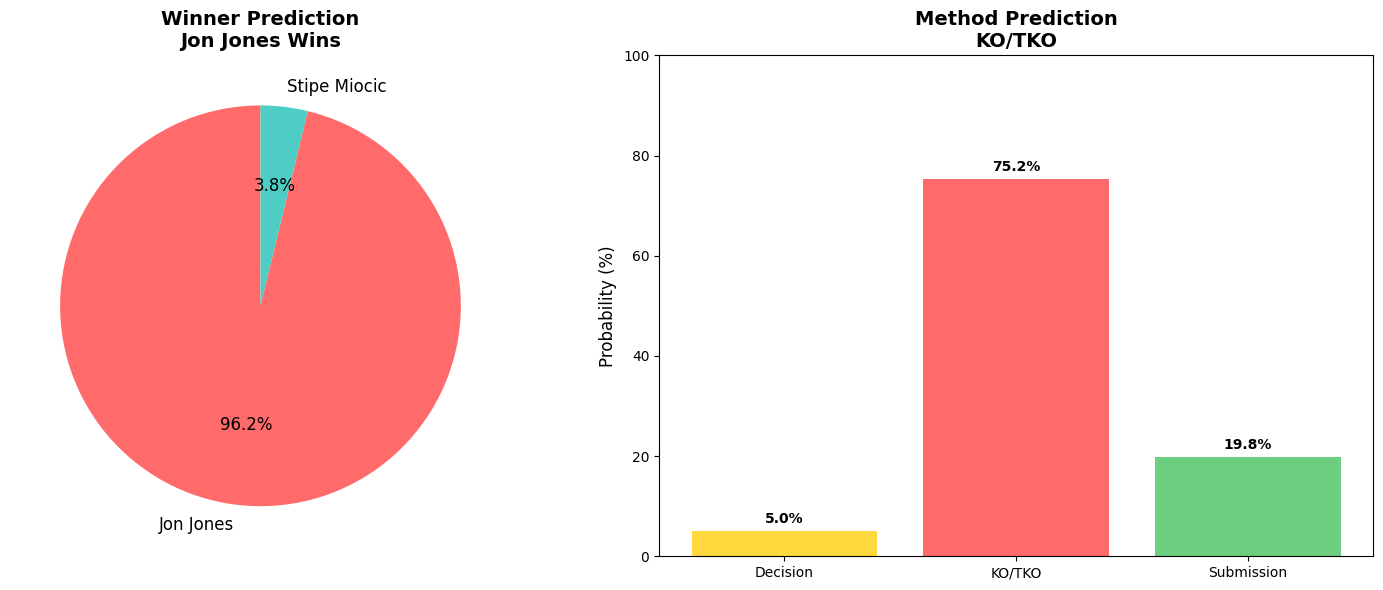

In [7]:
# Example: Single fight prediction
fighter1 = "Jon Jones"
fighter2 = "Stipe Miocic"

prediction = predict_single_fight(fighter1, fighter2, show_plot=True)


🎯 UFC Card Schedule:
   1. Ilia Topuria vs. Charles Oliveira
   2. Alexandre Pantoja vs. Kai Kara-France
   3. Brandon Royval vs. Joshua Van
   4. Beneil Dariush vs. Renato Moicano
   5. Payton Talbott vs. Felipe Lima
   6. Niko Price vs. Jacobe Smith
   7. Jhonata Diniz vs. Alvin Hines
   8. Jack Hermansson vs. Gregory Rodrigues
   9. Hyder Amil vs. Jose Delgado
   10. Viviane Araujo vs. Tracy Cortez
   11. Terrance McKinney vs. Viacheslav Borshchev
🃏 Predicting 11 fights...
Fight 1: Ilia Topuria vs Charles Oliveira
  🏆 Winner: Ilia Topuria (84.28%)
  ⚔️  Method: KO/TKO

Fight 2: Alexandre Pantoja vs Kai Kara-France
  🏆 Winner: Alexandre Pantoja (80.42%)
  ⚔️  Method: KO/TKO

Fight 3: Brandon Royval vs Joshua Van
  🏆 Winner: Joshua Van (81.38%)
  ⚔️  Method: KO/TKO

Fight 4: Beneil Dariush vs Renato Moicano
  🏆 Winner: Beneil Dariush (91.22%)
  ⚔️  Method: KO/TKO

Fight 5: Payton Talbott vs Felipe Lima
  🏆 Winner: Payton Talbott (85.72%)
  ⚔️  Method: KO/TKO

Fight 6: Niko Price vs Ja

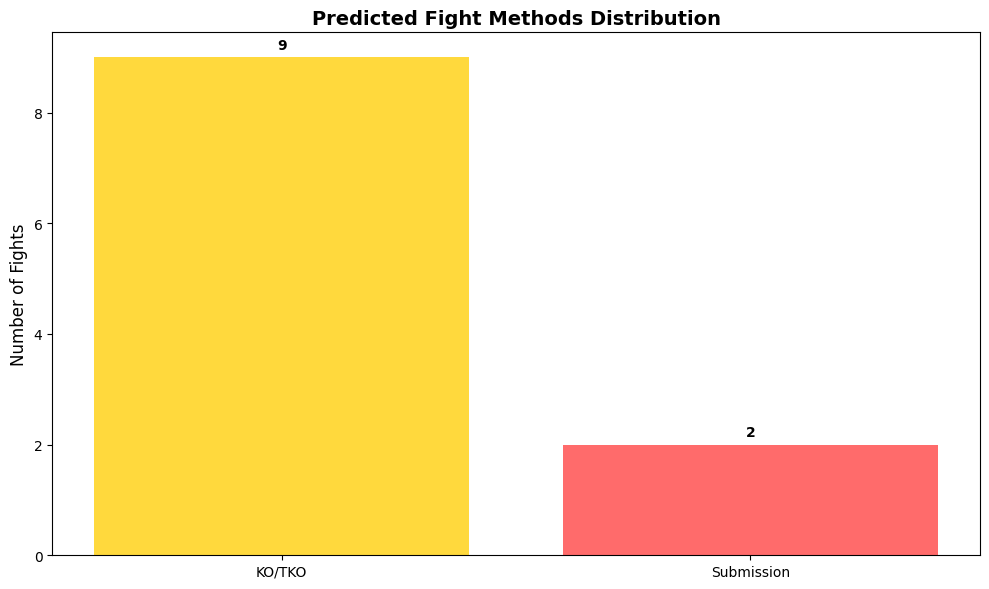

In [8]:
# Define your UFC card fights
ufc_card_fights = [
    "Ilia Topuria vs. Charles Oliveira",
    "Alexandre Pantoja vs. Kai Kara-France",
    "Brandon Royval vs. Joshua Van",
    "Beneil Dariush vs. Renato Moicano",
    "Payton Talbott vs. Felipe Lima",
    "Niko Price vs. Jacobe Smith",
    "Jhonata Diniz vs. Alvin Hines",
    "Jack Hermansson vs. Gregory Rodrigues",
    "Hyder Amil vs. Jose Delgado",
    "Viviane Araujo vs. Tracy Cortez",
    "Terrance McKinney vs. Viacheslav Borshchev"
]

print("🎯 UFC Card Schedule:")
for i, fight in enumerate(ufc_card_fights, 1):
    print(f"   {i}. {fight}")

# Predict the entire card
card_results = predict_multiple_fights(ufc_card_fights, show_summary=True)


In [9]:
# Profitability analysis setup
print("💰 Profitability analysis ready - using stealth TAB scraper!")


💰 Profitability analysis ready - using stealth TAB scraper!


In [10]:
def scrape_live_tab_odds(card_results=None):
    """STEP 1: Scrape live TAB odds (run once, cache results)."""
    
    print("🕵️  STEP 1: LIVE TAB ODDS SCRAPING")
    print("=" * 50)
    print("💡 Uses search engines to find exact TAB pages!")
    print("🚫 No more bot detection or wrong fighter matching!")
    
    # Extract fight card
    fight_card = []
    if card_results and 'fight_predictions' in card_results:
        for prediction in card_results['fight_predictions']:
            fight_card.append(prediction['fight'])
        print(f"✅ Fight card: {fight_card}")
    else:
        print("⚠️  No card results - using demo fight")
        fight_card = ["Conor McGregor vs. Khabib Nurmagomedov"]
    
    try:
        from src.stealth_tab_profitability import StealthTABProfitabilityAnalyzer
        
        # Initialize analyzer (just for scraping)
        analyzer = StealthTABProfitabilityAnalyzer(bankroll=1000)
        print("✅ Stealth scraper ready")
        
        # Get live odds (this is the slow part)
        live_odds_data = analyzer.get_live_tab_odds(fight_card)
        
        # Clean up scraper
        analyzer.close()
        
        print(f"✅ Scraping complete! Found odds for {len(live_odds_data)} fights")
        print("💾 Odds data cached - you can now run analysis multiple times without re-scraping")
        return live_odds_data
        
    except Exception as e:
        print(f"❌ Scraping error: {e}")
        return None

def analyze_cached_odds(card_results=None, live_odds_data=None, bankroll=1000):
    """STEP 2: Analyze cached odds data (fast, can re-run with different settings)."""
    
    print("🎯 STEP 2: PROFITABILITY ANALYSIS")
    print("=" * 45)
    print("💰 Analyzing cached odds data...")
    
    if not live_odds_data:
        print("❌ No odds data available - run scraping step first")
        return None
    
    # Extract predictions
    my_predictions = {}
    if card_results and 'fight_predictions' in card_results:
        for prediction in card_results['fight_predictions']:
            for fighter_name, prob_str in prediction['win_probabilities'].items():
                prob_decimal = float(prob_str.replace('%', '')) / 100
                my_predictions[fighter_name] = prob_decimal
        print(f"✅ Extracted {len(my_predictions)} predictions")
    else:
        print("⚠️  Using demo predictions")
        my_predictions = {"Conor McGregor": 0.16, "Khabib Nurmagomedov": 0.84}
    
    print(f"💳 Bankroll: ${bankroll} AUD")
    
    try:
        from src.stealth_tab_profitability import StealthTABProfitabilityAnalyzer
        
        # Create analyzer for analysis only (no scraping)
        analyzer = StealthTABProfitabilityAnalyzer(bankroll=bankroll)
        
        # Process the cached data directly
        results = analyzer.process_cached_odds(my_predictions, live_odds_data)
        
        return results
        
    except Exception as e:
        print(f"❌ Analysis error: {e}")
        return None

# 💡 SEPARATED WORKFLOW FUNCTIONS DEFINED ABOVE
# Use the next two cells for the improved separated workflow:
# - STEP 1: Scrape odds (slow, run once)  
# - STEP 2: Analyze profitability (fast, can re-run with different settings)

print("✅ Separated profitability analysis functions ready!")
print("📝 Functions available:")
print("   • scrape_live_tab_odds() - for odds scraping")  
print("   • analyze_cached_odds() - for fast analysis")
print("\n💡 Use the next two cells for the separated workflow")


✅ Separated profitability analysis functions ready!
📝 Functions available:
   • scrape_live_tab_odds() - for odds scraping
   • analyze_cached_odds() - for fast analysis

💡 Use the next two cells for the separated workflow


In [11]:
# 🕵️ STEP 1: Scrape Live TAB Odds (Run this first, only once per session)

if 'card_results' in locals():
    print("🎯 Scraping odds for current fight card...")
    cached_odds_data = scrape_live_tab_odds(card_results=card_results)
else:
    print("⚠️  No card results - run fight predictions first")
    cached_odds_data = None


🎯 Scraping odds for current fight card...
🕵️  STEP 1: LIVE TAB ODDS SCRAPING
💡 Uses search engines to find exact TAB pages!
🚫 No more bot detection or wrong fighter matching!
✅ Fight card: ['Ilia Topuria vs Charles Oliveira', 'Alexandre Pantoja vs Kai Kara-France', 'Brandon Royval vs Joshua Van', 'Beneil Dariush vs Renato Moicano', 'Payton Talbott vs Felipe Lima', 'Niko Price vs Jacobe Smith', 'Jhonata Diniz vs Alvin Hines', 'Jack Hermansson vs Gregory Rodrigues', 'Hyder Amil vs Jose Delgado', 'Viviane Araujo vs Tracy Cortez', 'Terrance McKinney vs Viacheslav Borshchev']
✅ Stealth scraper ready
🕵️  GETTING LIVE TAB ODDS WITH STEALTH SCRAPING
🕵️  STEALTH TAB SCRAPER - MULTIPLE FIGHTS
💡 Using DuckDuckGo + stealth techniques to avoid detection!
🕵️  Setting up stealth WebDriver...
✅ Stealth WebDriver initialized

🎯 Fight 1/11: Ilia Topuria vs Charles Oliveira

🥊 STEALTH SCRAPING: Ilia Topuria vs Charles Oliveira
🔍 DuckDuckGo search: "Ilia Topuria vs Charles Oliveira" site:tab.com.au
   📍 L

KeyboardInterrupt: 

In [ ]:
# 🎯 STEP 2: Analyze Profitability (Run this to see results, can re-run with different bankroll)

if 'cached_odds_data' in locals() and cached_odds_data:
    print("💰 Analyzing profitability with cached odds data...")
    
    # You can change the bankroll here and re-run without scraping again!
    profitability_results = analyze_cached_odds(
        card_results=card_results,
        live_odds_data=cached_odds_data,
        bankroll=25  # 🔄 Change this value and re-run this cell only!
    )
    
    print("\n✅ Analysis complete!")
    print("💡 To change bankroll, modify the value above and re-run this cell only")
    print("🚫 No need to re-scrape odds data!")
    
else:
    print("❌ No cached odds data available")
    print("💡 Run the scraping step (STEP 1) first")


💰 Analyzing profitability with cached odds data...
🎯 STEP 2: PROFITABILITY ANALYSIS
💰 Analyzing cached odds data...
✅ Extracted 22 predictions
💳 Bankroll: $25 AUD
💰 PROCESSING CACHED ODDS DATA
📊 Analyzing 11 fights with H2H odds
-----------------------------------

📊 SINGLE BET ANALYSIS RESULTS
💰 Profitable opportunities: 8
💵 Total expected profit: $7.03

🎯 RECOMMENDED SINGLE BETS:
------------------------------
1. Charles Oliveira @ 4.5 (vs Ilia Topuria)
   💰 Bet $1.25 → Expected profit: $0.45
   📈 Expected Value: 36.1%

2. Joshua Van @ 1.8 (vs Brandon Royval)
   💰 Bet $1.25 → Expected profit: $0.12
   📈 Expected Value: 9.4%

3. Beneil Dariush @ 2.0 (vs Renato Moicano)
   💰 Bet $1.25 → Expected profit: $0.20
   📈 Expected Value: 15.7%

4. Niko Price @ 11.0 (vs Jacobe Smith)
   💰 Bet $1.25 → Expected profit: $4.63
   📈 Expected Value: 370.4%

5. Jack Hermansson @ 2.65 (vs Gregory Rodrigues)
   💰 Bet $1.25 → Expected profit: $0.33
   📈 Expected Value: 26.5%

6. Hyder Amil @ 2.25 (vs Jos

🥊 Predicting: Conor McGregor vs Khabib Nurmagomedov
🏆 Predicted Winner: Khabib Nurmagomedov (84.23%)
⚔️  Predicted Method: KO/TKO

📊 Win Probabilities:
   Conor McGregor: 15.77%
   Khabib Nurmagomedov: 84.23%

🥊 Method Probabilities:
   Decision: 5.23%
   KO/TKO: 53.47%
   Submission: 41.29%


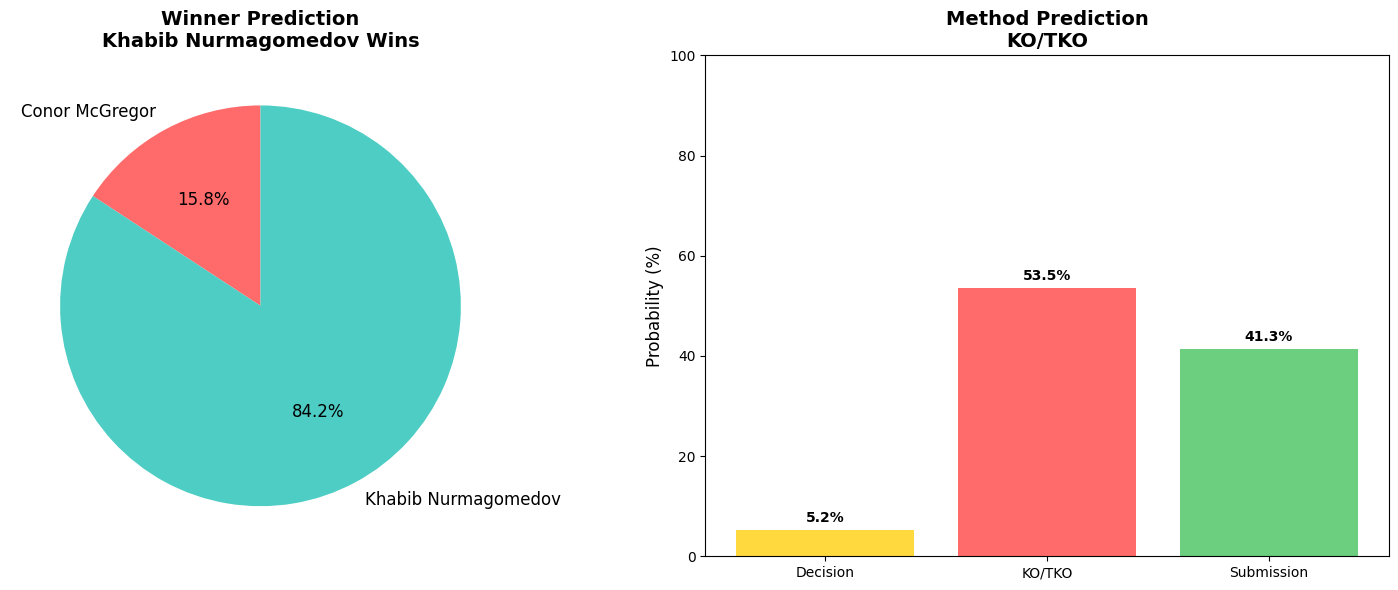

In [ ]:
# YOUR CUSTOM SINGLE FIGHT PREDICTION
# Modify these fighter names to predict any matchup

my_fighter1 = "Conor McGregor"
my_fighter2 = "Khabib Nurmagomedov"

my_prediction = predict_single_fight(my_fighter1, my_fighter2, show_plot=True)


🃏 Predicting 3 fights...
Fight 1: Jon Jones vs Stipe Miocic
  🏆 Winner: Jon Jones (81.90%)
  ⚔️  Method: KO/TKO

Fight 2: Islam Makhachev vs Arman Tsarukyan
  🏆 Winner: Islam Makhachev (78.75%)
  ⚔️  Method: Submission

Fight 3: Sean O'Malley vs Merab Dvalishvili
  🏆 Winner: Merab Dvalishvili (68.35%)
  ⚔️  Method: KO/TKO

📊 EVENT SUMMARY
Total Fights: 3
Successful Predictions: 3
Failed Predictions: 0
Success Rate: 100.0%

🥊 METHOD BREAKDOWN:
  KO/TKO: 2 fights (66.7%)
  Submission: 1 fights (33.3%)


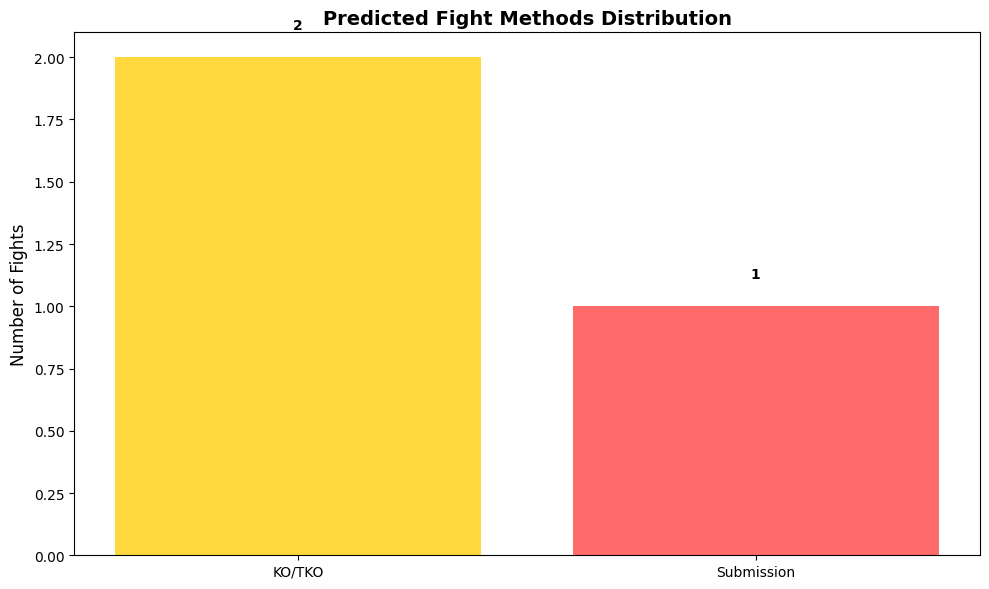

NameError: name 'run_stealth_profitability_analysis' is not defined

In [ ]:
# YOUR CUSTOM CARD PREDICTIONS
# Add your own list of fights to predict

my_custom_card = [
    "Jon Jones vs. Stipe Miocic",
    "Islam Makhachev vs. Arman Tsarukyan",
    "Sean O'Malley vs. Merab Dvalishvili"
]

# Run predictions
my_card_results = predict_multiple_fights(my_custom_card, show_summary=True)

# Run STEALTH profitability analysis on your custom card
my_profitability = run_stealth_profitability_analysis(
    card_results=my_card_results, 
    bankroll=1000  # 🕵️ Now uses STEALTH search to find exact TAB pages!
)
